# Drift Simulator

## User Specifications

In [1]:
drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'

iip_season = 2015  # must be 2015 (more to come later)
iip_indices = range(3284, 3286)  # must be of type list or range

## Imports

In [2]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc

if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from icedef.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [3]:
iip_season = 2015  # must be 2015 (more to come later)

iip_df = iceberg.add_datetime_column(iceberg.get_iip_df(iip_season))

iip_df = iip_df.sort_values(['ICEBERG_NUMBER', 'TIMESTAMP'], ascending=[True, True])

iip_df = iip_df.reset_index(drop=True)

#%%timeit

berg_nums = iip_df['ICEBERG_NUMBER'].tolist()
berg_times = iip_df['TIMESTAMP'].tolist()

berg_num = berg_nums[0]

good_indices = []

for i, row in iip_df.iterrows():
        
    if i+1 >= len(iip_df):
        break
        
    berg_num0 = berg_nums[i]
    berg_num1 = berg_nums[i+1]

    if berg_num0 == berg_num1:

        time0 = berg_times[i]
        time1 = berg_times[i+1]
        dtime = time1 - time0
        dt_hours = dtime.days*24 + dtime.seconds/3600
        
        if dt_hours < 12:
            good_indices.append(i)
            good_indices.append(i+1)

good_indices = sorted(list(set(good_indices)))

iip_df2 = iip_df[iip_df.index.isin(good_indices)]

iip_df2['count'] = iip_df2.groupby('ICEBERG_NUMBER')['ICEBERG_NUMBER'].transform('count')

iip_df2 = iip_df2.sort_values(['count', 'ICEBERG_NUMBER','TIMESTAMP'], ascending=[False, True, True])

df_20668 = iip_df2.loc[iip_df2['ICEBERG_NUMBER']==20668].reset_index(drop=True)

df_20668 = df_20668[2:8].reset_index(drop=True)

df_20668

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP,count
0,2015,20668,6/25/2015,1118,47.55,-49.51,R/V,SM,GEN,GTJZ,2015-06-25 11:18:00,10
1,2015,20668,6/25/2015,1918,47.43,-49.50,R/V,SM,GEN,GPGR,2015-06-25 19:18:00,10
2,2015,20668,6/26/2015,1046,47.43,-49.60,R/V,GEN,GEN,GTJZ,2015-06-26 10:46:00,10
3,2015,20668,6/26/2015,1646,47.44,-49.60,R/V,LG,GEN,GMRS,2015-06-26 16:46:00,10
4,2015,20668,6/27/2015,1104,47.45,-49.61,R/V,LG,GEN,GPGR,2015-06-27 11:04:00,10
5,2015,20668,6/27/2015,1331,47.35,-49.58,RAD,GEN,GEN,2005,2015-06-27 13:31:00,10


In [4]:
iip_berg = iceberg.get_iip_berg(df_20668)

## Metocean Data

In [5]:
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['20150625.nc', '20150626.nc', '20150627.nc']

In [6]:
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['20150625.nc', '20150626.nc', '20150627.nc']

## Simulate Drift

In [7]:
def berg_in_bounds(x_bounds, y_bounds, x, y):
        
    xmin = x_bounds[0]
    xmax = x_bounds[1]
    ymin = y_bounds[0]
    ymax = y_bounds[1]
        
    if not xmin < x < xmax:
        print('Iceberg out-of-bounds')
        return False

    elif not ymin < y < ymax:
        print('Iceberg out-of-bounds')
        return False
    
    else:
        return True

In [44]:
vary_currents = True
vary_winds = True
vary_drag_coeffs = True
vary_berg_dims = True
vary_berg_initial_vels = True



# Timesteps
t_step_hours = 0.1

t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

    
    

# Current and wind subsets
UW_data_subset = metocean.get_data_subset(ocean_data.UW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
            min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
            min(iip_berg.history['X']), max(iip_berg.history['X']))
VW_data_subset = metocean.get_data_subset(ocean_data.VW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))

UA_data_subset = metocean.get_data_subset(atm_data.UA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))
VA_data_subset = metocean.get_data_subset(atm_data.VA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))


    

    
num_runs = 2  
mod_berg_list = []

for run_num in range(num_runs):
    
    # Get offset that will be applied to all current and wind values
    if vary_currents:
        UW_offset = metocean.get_current_offset(UW_data_subset)
        VW_offset = metocean.get_current_offset(VW_data_subset)

    if vary_winds:
        UA_offset = metocean.get_wind_offset(UA_data_subset)
        VA_offset = metocean.get_wind_offset(VA_data_subset)



    # Model iceberg
    mod_berg = iceberg.clone_iceberg_state(iip_berg)

    if vary_drag_coeffs:
        mod_berg.vary_all_drag_coeffs()

    if vary_berg_dims:
        mod_berg.vary_all_dims()

    if vary_berg_initial_vels:
        # Iceberg travels at roughly 2% of the wind speed (rule of thumb)
        UA_mean = metocean.get_data_stats(UA_data_subset)[0]
        mod_berg.Vx = 0.02*UA_mean
        VA_mean = metocean.get_data_stats(VA_data_subset)[0]
        mod_berg.Vy = 0.02*VA_mean



    # Constants
    earth_radius = 6378*1e3  # radius of Earth  (m)


    # Buffer number for bounding spatial box
    drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
    drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
    drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
    drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))
    x_bounds = [drift_xmin, drift_xmax]
    y_bounds = [drift_ymin, drift_ymax]


    for t in t_all:

        mod_berg.T = t

        # Wind and ocean current velocities
        T_ocean = nc.date2num(mod_berg.T, ocean_data.t_units, ocean_data.t_calendar)
        T_atm = nc.date2num(mod_berg.T, atm_data.t_units, atm_data.t_calendar)
        Vcx = ocean_data.iUW([T_ocean, mod_berg.Y, mod_berg.X])[0] 
        Vcy = ocean_data.iVW([T_ocean, mod_berg.Y, mod_berg.X])[0] 
        Vax = atm_data.iUA([T_atm, mod_berg.Y, mod_berg.X])[0]  
        Vay = atm_data.iVA([T_atm, mod_berg.Y, mod_berg.X])[0]  

        # Offset the current and winds by some constant value
        Vcx += UW_offset
        Vcy += VW_offset
        Vax += UA_offset
        Vay += VA_offset

        # Drift
        Ax, Ay = drift(mod_berg, Vax, Vay, Vcx, Vcy)
        mod_berg.Vx += dt*Ax
        mod_berg.Vy += dt*Ay

        # Iceberg position (note the conversion from meters back to degrees)
        y_ = mod_berg.Y
        mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))
        mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))

        
        if mod_berg.in_bounds(x_bounds, y_bounds):
            mod_berg.update_history()        
        else:
            break

    print("Final time: {}".format(t)) 
    mod_berg_list.append(mod_berg)

Final time: 2015-06-27 13:36:00
Final time: 2015-06-27 13:36:00


## Timesteppers

In [82]:
# Timesteps
t_step_hours = 0.1

t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

In [83]:
def AB2(berg, ocean_data, atm_data, drift, t_all):
    
    Re = 6378*1e3  # radius of Earth
    
    # determine bounding box for drift simulation
    drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
    drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
    drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
    drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))
    x_bounds = [drift_xmin, drift_xmax]
    y_bounds = [drift_ymin, drift_ymax]
    
    # get timestep
    tdelta = t_all[1] - t_all[0]
    dt = tdelta.seconds
    
    for i, t in enumerate(t_all):
        
        berg.T = t
    
        # convert time to format used in metocean fields
        T_ocean = nc.date2num(berg.T, ocean_data.t_units, ocean_data.t_calendar)
        T_atm = nc.date2num(berg.T, atm_data.t_units, atm_data.t_calendar)
        
        # interpolate current and wind velocities for berg's [t, y, x]
        Vcx = ocean_data.iUW([T_ocean, berg.Y, berg.X])[0] 
        Vcy = ocean_data.iVW([T_ocean, berg.Y, berg.X])[0] 
        Vax = atm_data.iUA([T_atm, berg.Y, berg.X])[0]  
        Vay = atm_data.iVA([T_atm, berg.Y, berg.X])[0]
            
        # integrate
        if i < 1:
            # explicit Euler forward scheme
            berg.Vx += dt*berg.Ax
            berg.Vy += dt*berg.Ay   
            berg.Ax, berg.Ay = drift(berg, Vax, Vay, Vcx, Vcy)
            
        else:
            # second order Adams Bashforth
            berg.Vx += dt*(1.5*berg.Ax - 0.5*berg.history['Ax'][-1])
            berg.Vy += dt*(1.5*berg.Ay - 0.5*berg.history['Ay'][-1])
            berg.Ax, berg.Ay = drift(berg, Vax, Vay, Vcx, Vcy)
         
        # calculate position in degrees lat/lon
        y_ = berg.Y
        berg.Y += dt*berg.Vy*(180/(np.pi*Re))
        berg.X += dt*berg.Vx/(np.cos((((y_ + berg.Y)/2)*np.pi)/180))*(180/(np.pi*Re))
        
        # update date iceberg history if still in bounds
        if berg.in_bounds(x_bounds, y_bounds):
            berg.update_history()
        
        # otherwise, terminate
        else:
            break
      
    
    return berg
    
    """
    for i in range(N-1):

        t[i+1] = t[i] + dt

        if i < 1:
            # explicit Euler forward scheme
            vx[i+1] = vx[i] + dt*ax[i]
            vy[i+1] = vy[i] + dt*ay[i]

            ax[i+1], ay[i+1] = drift(berg, vx[i+1], vy[i+1], t[i+1])
        else:
            # second order Adams Bashforth
            vx[i+1] = vx[i] + dt*(1.5*ax[i]-0.5*ax[i-1])
            vy[i+1] = vy[i] + dt*(1.5*ay[i]-0.5*ay[i-1])

            ax[i+1], ay[i+1] = drift(berg, vx[i+1], vy[i+1], t[i+1])


        x[i+1] = x[i] + dt*vx[i+1]
        y[i+1] = y[i] + dt*vy[i+1]
    """


In [84]:
mod_berg = iceberg.clone_iceberg_state(iip_berg)
mod_berg = AB2(mod_berg, ocean_data, atm_data, drift, t_all)

## Plotting

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


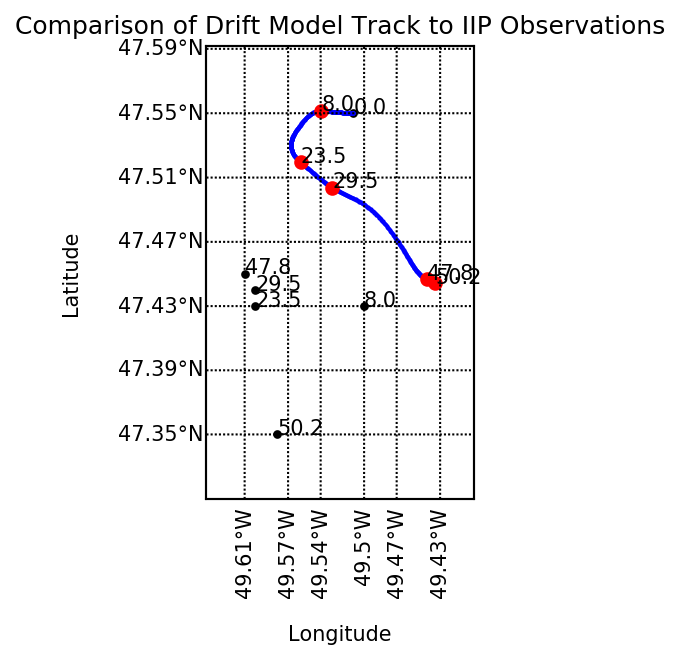

In [85]:
plot.plot_drift_track_test_case(iip_berg, mod_berg)

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


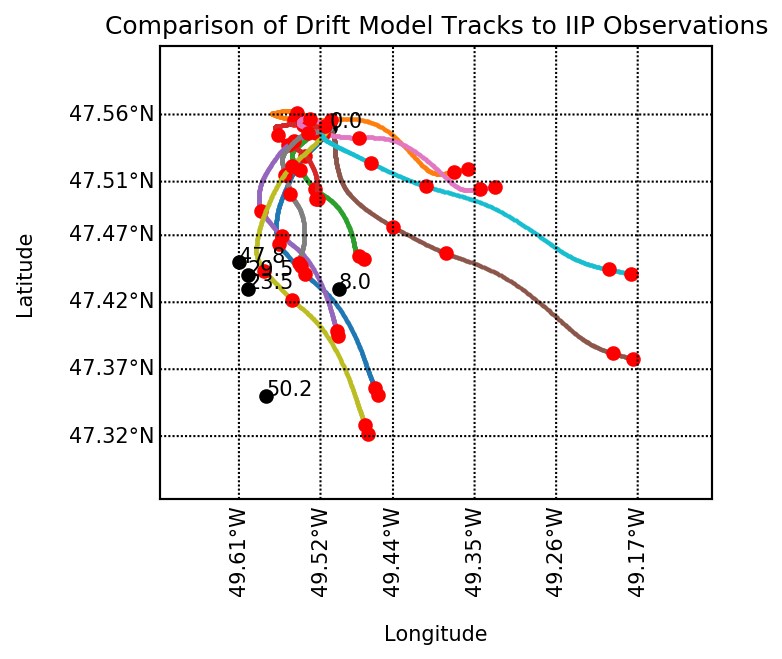

In [15]:
plot.plot_spaghetti_test_case(iip_berg, mod_berg_list)